### Table of Contents
*  [Introduction](#Introduction)

*  [EDA and Preprocessing](#EDA_PreProcessing)
    * [Encoding variables](#Encoding)
    * [Correlation](#Correlation)
    * [Some statistics](#Statitics)
    *  [Feature selection](#Feature_selection)
        * [Feature importance - Tree Based Classifier](#Feature_importance-CART)
        * [Permutation feature importance - sklearn](#PermutationFeatureImportance-Sklearn) 
    * [Train/Validation/Test split](#Train_Valid_Test)
    * [Resampling](#Resampling)
    * [PCA](#PCA)
*  [Machine Learning techniques](#Machine_Learning_techniques)
    * [Logistic Regression / CART / Random Forest / K-NN](#ML)
    * [Ensemble Learning models](#Ensemble_Learning)
    * [Hyperparameter Tuning](#Tuning)
    * [Clustering](#Clustering)
*  [Conclusion](#Conclusion)

# Introduction

In [32]:
import pandas as pd
import numpy as np
from word2number import w2n
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import collections
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings

warnings.filterwarnings('ignore')

ImportError: cannot import name 'available_if' from 'sklearn.utils.metaestimators' (C:\Users\Yalap\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py)

In [2]:
df = pd.read_csv('ParisHousing.csv')

In [3]:
df.head()

,Unnamed: 0,squareMeters,numberOfRooms,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,category,PoolAndYard
0,0,75523,three,63,9373,3,8,2005,False,True,4313,9005,956,False,7,7559081.5,Basic,has pool and no yard
1,1,80771,thirty-nine,98,39381,8,6,2015,True,False,3653,2436,128,True,2,8085989.5,Luxury,has pool and has yard
2,2,55712,fifty-eight,19,34457,6,8,2021,False,False,2937,8852,135,True,9,5574642.1,Basic,has pool and no yard
3,3,32316,forty-seven,6,27939,10,4,2012,False,True,659,7141,359,False,3,3232561.2,Basic,no pool and no yard
4,4,70429,nineteen,90,38045,3,7,1990,True,False,8435,2429,292,True,4,7055052.0,Luxury,has pool and has yard


In [4]:
# checking the column types
df.dtypes

Unnamed: 0             int64
squareMeters           int64
numberOfRooms         object
floors                 int64
cityCode               int64
cityPartRange          int64
numPrevOwners          int64
made                   int64
isNewBuilt              bool
hasStormProtector       bool
basement               int64
attic                  int64
garage                 int64
hasStorageRoom          bool
hasGuestRoom           int64
price                float64
category              object
PoolAndYard           object
dtype: object

In [5]:
df.columns

Index(['Unnamed: 0', 'squareMeters', 'numberOfRooms', 'floors', 'cityCode',
       'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price', 'category', 'PoolAndYard'],
      dtype='object')

In [6]:
df.isna().sum().sum()
# no missing values

0

In [7]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [8]:
pd.DataFrame(df['price'].describe()).T

,count,mean,std,min,25%,50%,75%,max
price,10000.0,4.993448e+06,2.877424e+06,10313.5,2516401.95,5016180.3,7469092.45,10006771.2


# Encoding variables

#### numberOfRooms

In [9]:
df.numberOfRooms.head()

0          three
1    thirty-nine
2    fifty-eight
3    forty-seven
4       nineteen
Name: numberOfRooms, dtype: object

In [10]:
#numberOfRooms
nb = []

for word in df["numberOfRooms"]:
    nb.append(w2n.word_to_num(word))
    
df["numberOfRooms"] = nb

In [11]:
df.numberOfRooms.head()

0     3
1    39
2    58
3    47
4    19
Name: numberOfRooms, dtype: int64

#### PoolAndYard

In [12]:
df.PoolAndYard.value_counts()
# créer une colonne pool et une colonne yard (binaires) puis supprimer celle là.

has pool and has yard    2566
no pool and has yard     2521
no pool and no yard      2511
has pool and no yard     2402
Name: PoolAndYard, dtype: int64

In [13]:
df['Pool'] = 0
df['Yard'] = 0

df.loc[df['PoolAndYard']=='has pool and has yard','Pool'] = 1
df.loc[df['PoolAndYard']=='has pool and has yard','Yard'] = 1
df.loc[df['PoolAndYard']=='no pool and has yard','Yard'] = 1
df.loc[df['PoolAndYard']=='has pool and no yard','Pool'] = 1

After creating two binary variables for Pool and Yard, we drop the original column. We will also drop the 'cityCode' colum as its unique values are almost all different. 

In [14]:
df.drop(['PoolAndYard','cityCode'],axis=1,inplace=True)

#### category

In [15]:
df.category.value_counts()

Basic     8735
Luxury    1265
Name: category, dtype: int64

In [16]:
from sklearn.preprocessing import LabelEncoder
label_var = LabelEncoder()
df['category'] = label_var.fit_transform(df['category'])

In [17]:
df['category'].value_counts()
# basic : 0
# luxury : 1

0    8735
1    1265
Name: category, dtype: int64

#### Booleans to numeric

In [18]:
# convert booleans to numeric
for col in ['isNewBuilt','hasStorageRoom','hasStormProtector']:
    df[col] = list(map(int, df[col]))

### Price Evolution by category

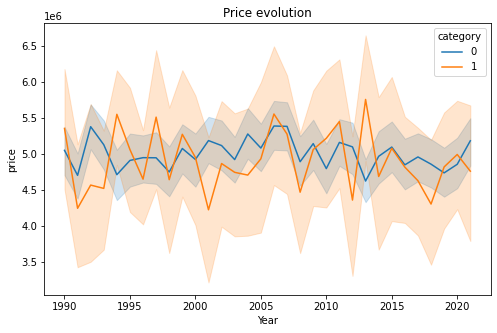

In [19]:
f, ax = plt.subplots(figsize=(8, 5))
fig = sns.lineplot(x = df["made"], y = df["price"] , hue = df["category"])
plt.xlabel('Year')
plt.title('Price evolution');

We notice that the prices have experienced a very flexible movement over the years. It is very likely that this is related to expansions and recessions following economic crises, such as the early 1990s recession caused by the October 1987 crash (fall of the Dow Jones Industrial Average), as well as the subprime mortgage crisis (2007/2008).

### Correlation Matrix

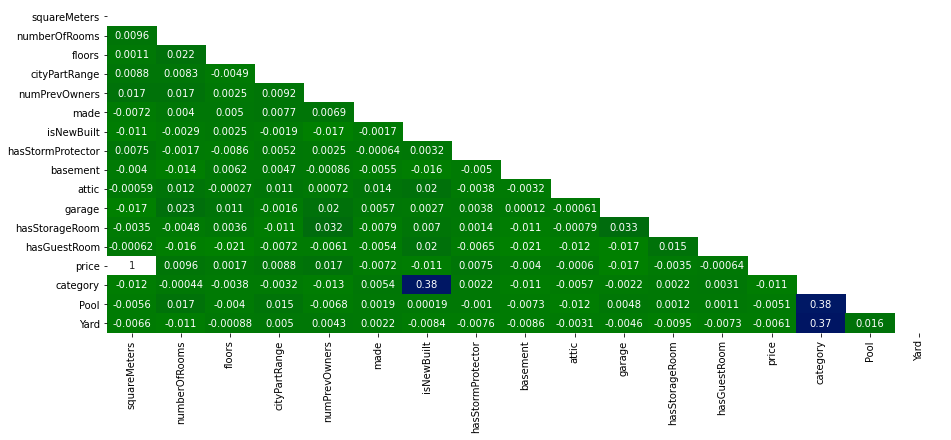

In [20]:
plt.figure(figsize=(15,6))
sns.heatmap(df.corr(),annot=True,cmap="ocean",cbar=False,mask=np.triu(np.ones_like(df.corr(), dtype = bool)))
plt.show()

In [24]:
corr_matrix = df.corr()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))

def top_correlation(df,n):
    correlation = upper_tri.stack().sort_values(ascending=False)
    correlation = pd.DataFrame(correlation).reset_index()
    correlation.columns=["Variable 1","Variable 2","Correlation"]
    correlation = correlation.reindex(correlation.Correlation.abs().sort_values(ascending=False).index).reset_index().drop(["index"],axis=1)
    return correlation.head(n)

top_correlation(df,10)

,Variable 1,Variable 2,Correlation
0,squareMeters,price,0.999999
1,category,Pool,0.382995
2,isNewBuilt,category,0.381237
3,category,Yard,0.373987
4,garage,hasStorageRoom,0.032863
5,numPrevOwners,hasStorageRoom,0.031707
6,numberOfRooms,garage,0.023188
7,numberOfRooms,floors,0.022244
8,floors,hasGuestRoom,-0.021155
9,basement,hasGuestRoom,-0.020732


In [25]:
df['price']/df['squareMeters']

0       100.089794
1       100.110058
2       100.061784
3       100.029744
4       100.172543
           ...    
9995    102.216628
9996    100.184087
9997    100.070735
9998    100.025527
9999    101.880833
Length: 10000, dtype: float64

There is a linear relationship between price and squaremeters (Price is almost 100* the square meters), we will drop one of them. But first, let's proceed to some statistical analysis on the those variables.

#### Some statistics on price variable
##### Skewness
- If skewness is less than −1 or greater than +1, the distribution is highly skewed.
- If skewness is between −1 and −½ or between +½ and +1, the distribution is moderately skewed.
- If skewness is between −½ and +½, the distribution is approximately symmetric.

##### Kurtosis
- A normal distribution has kurtosis exactly 3 (excess kurtosis exactly 0). Any distribution with kurtosis ≈3 (excess ≈0) is called mesokurtic.
- A distribution with kurtosis <3 (excess kurtosis <0) is called platykurtic. Compared to a normal distribution, its central peak is lower and broader, and its tails are shorter and thinner.
- A distribution with kurtosis >3 (excess kurtosis >0) is called leptokurtic. Compared to a normal distribution, its central peak is higher and sharper, and its tails are longer and fatter.

In [27]:
from scipy.stats import skew, kurtosis

for i in ['price','squareMeters']:
    skw = skew(df[i], bias=False)
    krt = kurtosis(df[i], bias=False)
    print(f'{i :}\nskewness : {round(skw,3)}\nkurtosis : {round(krt,3)}')

price
skewness : -0.006
kurtosis : -1.185
squareMeters
skewness : -0.006
kurtosis : -1.185


Both have a skewness of -0.006 (approximately symmetric distribution) and a kurtosis of -1.185 (platykurtic) which is not surprising because of the linear relationship between the two variables.

In [28]:
data = df.copy()

In [29]:
data.drop('price',axis=1,inplace=True) # we drop the price column

In [30]:
data.head()

,squareMeters,numberOfRooms,floors,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,category,Pool,Yard
0,75523,3,63,3,8,2005,0,1,4313,9005,956,0,7,0,1,0
1,80771,39,98,8,6,2015,1,0,3653,2436,128,1,2,1,1,1
2,55712,58,19,6,8,2021,0,0,2937,8852,135,1,9,0,1,0
3,32316,47,6,10,4,2012,0,1,659,7141,359,0,3,0,0,0
4,70429,19,90,3,7,1990,1,0,8435,2429,292,1,4,1,1,1


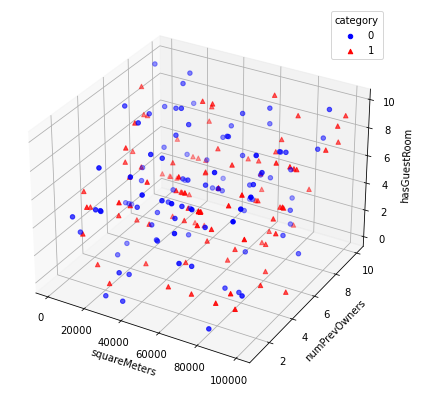

In [31]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

data0 = data[data['category']==0][:100][['squareMeters','numPrevOwners','hasGuestRoom','category']]
data1 = data[data['category']==1][:100][['squareMeters','numPrevOwners','hasGuestRoom','category']]

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111,projection='3d')

X0 = data0.squareMeters
Y0 = data0.numPrevOwners
Z0 = data0.hasGuestRoom

X1 = data1.squareMeters
Y1 = data1.numPrevOwners
Z1 = data1.hasGuestRoom

ax.scatter(X0,Y0,Z0,c='b',marker='o')
ax.scatter(X1,Y1,Z1,c='r',marker='^')

ax.set_xlabel('squareMeters')
ax.set_ylabel('numPrevOwners')
ax.set_zlabel('hasGuestRoom')
plt.legend(title='category',labels=data.category);

In [32]:
X = data.drop('category',axis=1)
y = data['category']

## FEATURE IMPORTANCE (using Tree Based Classifier)

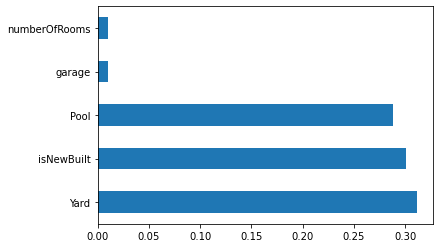

In [33]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
feat_imp = pd.Series(model.feature_importances_,index=X.columns)
feat_imp.nlargest().plot(kind='barh');

In [562]:
data.head()

,squareMeters,numberOfRooms,floors,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,category,Pool,Yard
0,75523,3,63,3,8,2005,0,1,4313,9005,956,0,7,0,1,0
1,80771,39,98,8,6,2015,1,0,3653,2436,128,1,2,1,1,1
2,55712,58,19,6,8,2021,0,0,2937,8852,135,1,9,0,1,0
3,32316,47,6,10,4,2012,0,1,659,7141,359,0,3,0,0,0
4,70429,19,90,3,7,1990,1,0,8435,2429,292,1,4,1,1,1


# Train Validation Test split 

When there are many parameters to tune, a validation set is often used because it prevents from overfitting. I decided to use those three sets but later on we will see that we will not really have to tune our models because algorithms will perform highly even without tuning them, so we could only use training and test sets.

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_rem, y_train, y_rem = train_test_split(X,y,train_size=0.6,random_state=16)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem,test_size=0.5,random_state=16)

In [35]:
print(f"data shape : {data.shape}\nX_train shape : {X_train.shape}\nX_valid shape : {X_valid.shape}\nX_test shape : {X_test.shape}")

data shape : (10000, 16)
X_train shape : (6000, 15)
X_valid shape : (2000, 15)
X_test shape : (2000, 15)


In [36]:
y_train.value_counts(normalize=True)

0    0.869833
1    0.130167
Name: category, dtype: float64

In [37]:
y_valid.value_counts(normalize=True)

0    0.8785
1    0.1215
Name: category, dtype: float64

In [38]:
y_test.value_counts(normalize=True)

0    0.8795
1    0.1205
Name: category, dtype: float64

After checking the class proportions, we can see that they are almost similar, so there is no need to use the ```stratify=y``` argument during the split.

# Resampling the target variable

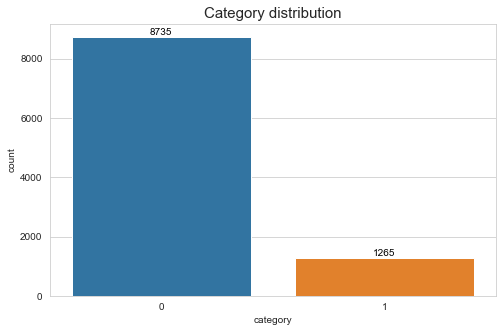

In [39]:
sns.set_style('whitegrid')
plt.figure(figsize=(8,5))
ax = sns.countplot(data['category'])
for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')
plt.title('Category distribution',size=15);

As we can see above, the data is imbalanced. There are several techniques that allow us to balance our data.

<font color='red'>**1. Undersampling** :</font>
minority class (NearMiss)

**Pros :**
- Reduces storage problems, easy to train.
- Produces a simple random sample which is much less complicated than other techniques.

**Cons :**
- Ignores data (information of the majority class) which could be important for building  classifiers.
- Sampling may be biased.

<font color='red'>**2. Oversampling** :</font> majority class (SMOTE, SMOTETomek, Random Oversampler), in case of oversampling, we are not losing data.\
Oversampling is more efficient than undersamplig because in undersampling we are losing some amount of data whereas in oversampling we are not. We create more data, we fix the umbalanced set.

Random Oversampling creates duplicates of the training data set examples and thus does not increase variety, whereas SMOTE technique creates new (artificial) training data based on the original ones by creating convex combinations of neighboring instances which leads to an increase in variety.

We will use the SMOTE (Synthetic Minority Oversampling TEchnique) method for this dataset.

###### SMOTE

In [40]:
# resampling sur le train
sm = SMOTE(random_state=16)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("Before smote --> ", collections.Counter(y_train))
print("After smote --> ", collections.Counter(y_train_sm))

Before smote -->  Counter({0: 5219, 1: 781})
After smote -->  Counter({0: 5219, 1: 5219})


In [41]:
X_old = pd.DataFrame(X_train, columns=['attic', 'squareMeters'])
y_old = pd.Series(y_train)
X_res = pd.DataFrame(X_train_sm, columns=['attic', 'squareMeters'])
y_res = pd.Series(y_train_sm)

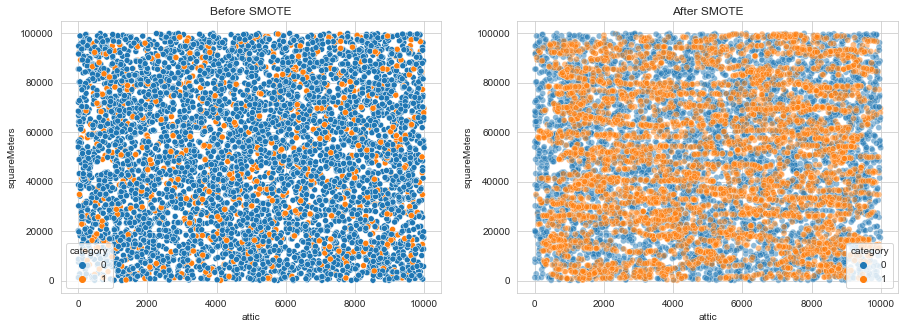

In [42]:
f, axes = plt.subplots(1,2,figsize=(15,5))
s1 = sns.scatterplot(data=X_old, x="attic", y="squareMeters", hue=y_old, alpha=1,ax=axes[0])
axes[0].set_title('Before SMOTE')
s2 = sns.scatterplot(data=X_res, x="attic", y="squareMeters", hue=y_res, alpha=0.5,ax=axes[1])
axes[1].set_title('After SMOTE');

As we can see above, the SMOTE technique created some artificial data. One should consider that this method can sometimes create meaningless data so we should be aware when using such oversampling techniques.

# Principal Component Analysis (PCA)

Original data shape : (10438, 15)
PCA shape : (10438, 2)


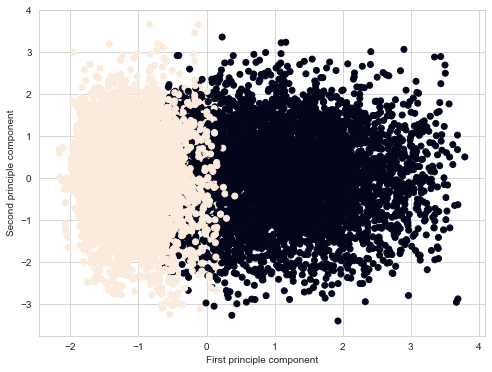

In [43]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train_sm)

pca=PCA(n_components=2)

pca.fit(scaled_data)
x_pca=pca.transform(scaled_data)
print(f'Original data shape : {scaled_data.shape}\nPCA shape : {x_pca.shape}')

plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=y_train_sm)
plt.xlabel('First principle component')
plt.ylabel('Second principle component');

The graph above shows that the two classes, when projected to a two-dimensional space, can be separable up to some extent. Moreover, the class in black spread out as compared to the other class.

# Machine Learning techniques

First, we will group the algorithms in a pipeline to get an idea of the performance without tuning them. Subsequently, we will tune each algorithm with a different method such as GridSearchCV, RandomizedSearchCV and Optuna.

## LogisticRegression, CART, Random Forest, K-NN

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression # sc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


pipeline_lr = Pipeline([('scalar1', StandardScaler()),('lr_classifier',LogisticRegression(random_state=16))])
pipeline_dt = Pipeline([('dt_classifier',DecisionTreeClassifier(random_state=16))])
pipeline_rf = Pipeline([('rf_classifier',RandomForestClassifier(random_state=16))])
pipeline_knn = Pipeline([('knn_classifier',KNeighborsClassifier(n_neighbors=3))])

pipelines = [pipeline_lr,pipeline_dt,pipeline_rf,pipeline_knn]

best_accuracy = 0
best_classifier = 0
best_pipeline = ""

pipe_dict = {0:'Logistic Regression', 1:'Decision Tree',2:'Random Forest',3:'K-NN'}

In [45]:
for pipe in pipelines:
    pipe.fit(X_train_sm,y_train_sm)
    
for i,model in enumerate(pipelines):
    print("{} Train Accuracy : {}".format(pipe_dict[i],model.score(X_train_sm,y_train_sm).round(3)))

for i,model in enumerate(pipelines):
    if model.score(X_train_sm,y_train_sm)>best_accuracy:
        best_accuracy = model.score(X_train_sm,y_train_sm)
        best_pipeline = model
        best_classifier = i
print("Classifier with best accuracy : {}".format(pipe_dict[best_classifier]))

Logistic Regression Train Accuracy : 1.0
Decision Tree Train Accuracy : 1.0
Random Forest Train Accuracy : 1.0
K-NN Train Accuracy : 0.89
Classifier with best accuracy : Logistic Regression


We notice that our models performed really good on the training sets with default parameters. Next, we are going to check if they perform as well in the validation and test sets.

There are different metrics that can be used to evaluate the performance of our models (**Accuracy, Recall, Precision, F-Beta, Cohen Kappa, ROC/AUC etc**). On the one hand, if the data is **balanced** then accuracy can be used. On the other hand, if the data is **imbalanced**, accuracy should not be used because the algorithm will always predict the most occurent class and this we lead to a (biased) high accuracy, unless we resample it.

**Accuracy :** also known as Correct Prediction Ratio (CPR), is the number of correct predictions
over the total number of predictions. Accuracy basically measures the events that were correctly
predicted by the model and it can be used with a balanced dataset.
$$Accuracy = \frac{TP+TN}{TP+FP+TN+FN}$$

Using a pipeline and without tuning, we notice that the best classifiers à priori are the Decision Tree and the Random Forest classifiers. Later on we will tune the hyperparameters of some parameters and see how the performance will increase.

# CART 

In [46]:
cart_clf = DecisionTreeClassifier(criterion='gini')
cart_clf.fit(X_train_sm,y_train_sm)
y_cart_valid = cart_clf.predict(X_valid)
y_cart_test = cart_clf.predict(X_test)
print("CART Accuracy on Train Dataset : {}".format(cart_clf.score(X_train_sm, y_train_sm)))
print("CART Accuracy on Validation  Dataset : {}".format(accuracy_score(y_valid,y_cart_valid).round(3)))

CART Accuracy on Train Dataset : 1.0
CART Accuracy on Validation  Dataset : 1.0


This might be surprising in the first glance, a perfect performance in the training as well as the test and validations.. But since the model does not overfit plus the classes repartition is balanced, I think that it is due to the fact that the data gives too much information which easily lead us to have perfect predictions even do the variables are not independently correlated to the category.
I also thought that if we predict the probabilities instead, the result might change but I tried with many different thresholds and the result stayed the same : a perfectly perfect model.

In [47]:
# Avec predict proba()
THRESHOLD = 0.8
model_tree = DecisionTreeClassifier(random_state=16)
model_tree.fit(X_train_sm,y_train_sm)
y_prdtr = np.where(model_tree.predict_proba(X_valid)[:,1] >= THRESHOLD, 1, 0)
y_pred_proba_new_threshold = (model_tree.predict_proba(X_valid)[:,1] >= THRESHOLD).astype(int)
print("CART Accuracy on Train Dataset : {}".format(model_tree.score(X_train_sm, y_train_sm)))
print("CART Accuracy on Validation  Dataset : {}".format(accuracy_score(y_valid,y_pred_proba_new_threshold).round(3)))

CART Accuracy on Train Dataset : 1.0
CART Accuracy on Validation  Dataset : 1.0


In [48]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_valid, y_pred_proba_new_threshold, n_bins=3)

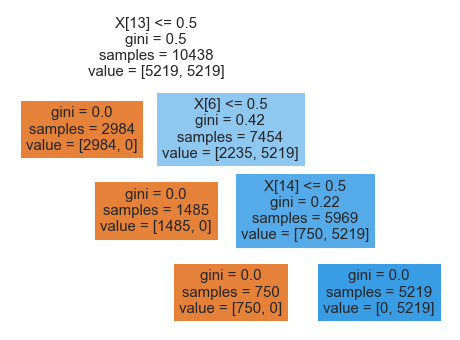

In [49]:
from sklearn import tree
plt.figure(figsize=(8,6))
tree.plot_tree(model_tree,filled=True);

We saw that the model performed very well and there is no need to tune it, but I am going to do so just to see if something will change (this tuning is thus optional).

In [56]:
parameters={"splitter":["best","random"],
            "max_depth" : [1,2,3],
           "min_samples_leaf":[1,5,10],
           "min_weight_fraction_leaf":[0.01,0.1,0.4],
           "max_features":["auto","log2","sqrt",None], # ne pas tout utiliser
           "max_leaf_nodes":[1,3,5,7],
           "criterion": ["gini"]}

In [57]:
tuning_model=GridSearchCV(model_tree,param_grid=parameters,scoring='accuracy',cv=5,verbose=1)

In [58]:
tuning_model.fit(X_train_sm,y_train_sm)
# in comment because it takes a lot of place even with a small verbose.

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 4320 out of 4320 | elapsed:  1.1min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=16),
             param_grid={'criterion': ['gini'], 'max_depth': [1, 2, 3],
                         'max_features': ['auto', 'log2', 'sqrt', None],
                         'max_leaf_nodes': [1, 3, 5, 7],
                         'min_samples_leaf': [1, 5, 10],
                         'min_weight_fraction_leaf': [0.01, 0.1, 0.4],
                         'splitter': ['best', 'random']},
             scoring='accuracy', verbose=1)

In [59]:
tuning_model.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': 5,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.01,
 'splitter': 'best'}

In [60]:
cart_tuned = DecisionTreeClassifier(criterion='gini',max_depth=3,max_features=None,max_leaf_nodes=5,min_samples_leaf=1,min_weight_fraction_leaf=0.01,splitter='best')
cart_tuned.fit(X_train_sm,y_train_sm)
y_cart_tuned = cart_tuned.predict(X_valid)
print("Tuned CART Accuracy on Train Dataset : {}".format(cart_tuned.score(X_train_sm, y_train_sm).round(3)))
print("Tuned CART Accuracy on Validation  Dataset : {}".format(accuracy_score(y_valid,y_cart_tuned).round(3)))

Tuned CART Accuracy on Train Dataset : 1.0
Tuned CART Accuracy on Validation  Dataset : 1.0


In the first try, the tuned version overfitted but I think that this is normal because when using the grid search, we give the algorithm a certain interval or values per parameter, so the optimal value might not be among those values and therefore we have to try many times until we converge to the optimal value. So in the second try by changing the values in the dictionary I converged to the optimal solution.

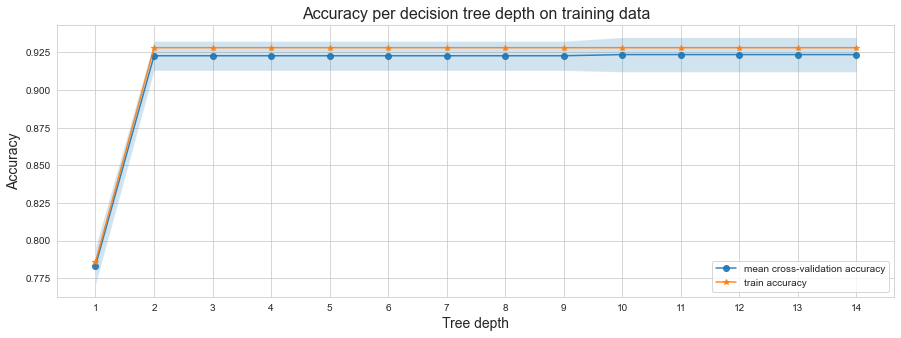

In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth,criterion='gini',max_features=None,max_leaf_nodes=5,min_samples_leaf=1,min_weight_fraction_leaf=0.1,splitter='random')
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# fitting trees of depth 1 to 15
sm_tree_depths = range(1,15)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train_sm, y_train_sm, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

# Bagging

Bootstrap Aggregating, also known as Bagging, is an ensemble learning meta-algorithm which aims to improve the accuracy of machine learning classification and regression algorithms. Bagging actually applies the principle of Bootstrap, meaning that is uses random sampling with replacement (an element may appear several times in the same sample) then aggregates the outcomes by applying the majority vote rule.\
In other words, the purpose behind the bagging method is to create decision trees that are pretty different from each other so as to reduce the variance comparing to the case of a sole decision tree, to avoid over-fitting.

Bagging Accuracy on Train Dataset : 1.0
Bagging Accuracy on Validation  Dataset : 1.0


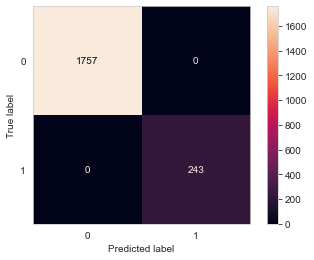

In [62]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=16)
bag_clf.fit(X_train_sm, y_train_sm)
y_pred_bg = bag_clf.predict(X_valid)

from sklearn.metrics import accuracy_score
roc_auc_bag = roc_auc_score(y_test, y_pred_bg)
print("Bagging Accuracy on Train Dataset : {}".format(bag_clf.score(X_train_sm, y_train_sm)))
print("Bagging Accuracy on Validation  Dataset : {}".format(accuracy_score(y_valid,y_pred_bg).round(3)))
plot_confusion_matrix(bag_clf, X_valid, y_valid,cmap=None)
plt.grid(False);

It is not surprising that the bagging performs very well too because the decesion trees also performed perfectly.

## Hyperparameter Tuning

### Logistic Regression (GridSearchCV)

We'll be optimizing 4 different hyperparameters of our logistic regression model :
- penalty
- C
- fit_intercept
- solver

In [63]:
# Feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler().fit(X_train_sm) # we fit on the training set
X_train_sc = sc.transform(X_train_sm)
X_valid_sc = sc.transform(X_valid) # same training scale for the validation

In [64]:
log_model = LogisticRegression(random_state=16)

param_grid = {'C': [0.001, 0.02, 0.01, 0.03, 0.1],
              'penalty': ['l1','l2'],
             'fit_intercept':[True,False],
             'solver': ["liblinear", "saga"]}

In [65]:
grid_search = GridSearchCV(estimator=log_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=15, verbose=1)

In [66]:
grid_search.fit(X_train_sc,y_train_sm) # scaled

Fitting 15 folds for each of 40 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   13.4s finished


GridSearchCV(cv=15, estimator=LogisticRegression(random_state=16), n_jobs=-1,
             param_grid={'C': [0.001, 0.02, 0.01, 0.03, 0.1],
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)

In [67]:
print(f'Best Estimator : {grid_search.best_estimator_}\nBest Parameters : {grid_search.best_params_}')
print(f'Best Score : {grid_search.best_score_.round(3)}')

Best Estimator : LogisticRegression(C=0.001, penalty='l1', random_state=16, solver='liblinear')
Best Parameters : {'C': 0.001, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score : 1.0


In [68]:
logist = LogisticRegression(C=0.001, penalty='l1',solver='liblinear')

In [69]:
# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
logist.fit(X_train_sc, y_train_sm)
y_pred_logist = logist.predict(X_valid_sc)
print(f'{confusion_matrix(y_valid, y_pred_logist)}\nValidation Accuracy : {accuracy_score(y_valid, y_pred_logist).round(3)}')

[[1757    0]
 [   0  243]]
Validation Accuracy : 1.0


In [70]:
print("Tuned Logistic Regression Accuracy on Train Dataset : {}".format(logist.score(X_train_sc, y_train_sm)))
print("Tuned Logistic Regression Accuracy on Validation  Dataset : {}".format(accuracy_score(y_valid,y_pred_logist)))
# overfitting ou le test et valid contiennent des infos deja dans le train, il faut analyser le train etc

Tuned Logistic Regression Accuracy on Train Dataset : 1.0
Tuned Logistic Regression Accuracy on Validation  Dataset : 1.0


### Tuning Random Forest
###### RandomSearchCV

In [71]:
rfc_model = RandomForestClassifier(random_state=16)

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [12,15,20] # minimum sample number to split a node
min_samples_leaf = [1,2, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rfc_random = RandomizedSearchCV(estimator = rfc_model, param_distributions = random_grid,
                                n_iter = 100, cv = 30, verbose=1, random_state=35, n_jobs = -1)

rfc_random.fit(X_train_sm,y_train_sm)
print(f'Best Estimator : {rfc_random.best_estimator_}')

Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 514 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 1976 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.9min finished


Best Estimator : RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=2,
                       min_samples_split=12, n_estimators=14, random_state=16)


In [72]:
rfc_opt = RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=2,min_samples_split=12, n_estimators=14)

Validation Accuracy Score: 1.0


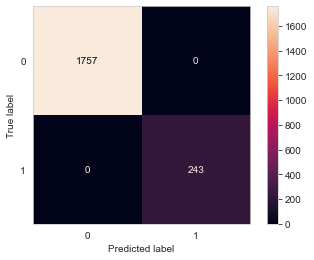

In [73]:
# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
rfc_opt.fit(X_train_sm, y_train_sm)
y_pred_rfc = rfc_opt.predict(X_valid)
roc_auc_bag = roc_auc_score(y_valid, y_pred_rfc)
print(f'Validation Accuracy Score: {accuracy_score(y_valid, y_pred_rfc).round(3)}')
plot_confusion_matrix(rfc_opt, X_valid, y_valid,cmap=None)
plt.grid(False);

In [74]:
print(f'Train Accuracy : {rfc_opt.score(X_train_sm,y_train_sm).round(3)}')
rfprediction=rfc_opt.predict(X_valid)
print(f'Validation Accuracy : {accuracy_score(y_valid,rfprediction).round(3)}')
print(confusion_matrix(y_valid,rfprediction))

Train Accuracy : 1.0
Validation Accuracy : 1.0
[[1757    0]
 [   0  243]]


###### GridSearchCV

In [75]:
parameters = {
    'n_estimators': [1,5,10,15],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
}

est = RandomForestClassifier()
clf = GridSearchCV(est, parameters, cv=10)

clf.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [1, 5, 10, 15]})

To measure impurity (i.e. heterogeneity), we seek, among all the possible splits, the one that best separates the classes, namely the one that minimizes impurity so as to get the most homogeneous nodes.
Among the criteria used to measure this impurity are the Gini index and entropy.

In [76]:
clf.best_params_

{'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 15}

In [77]:
rfc_optg = RandomForestClassifier(criterion='gini',max_features='sqrt', n_estimators=14)
rfc_optg.fit(X_train_sm, y_train_sm)
y_predrfc = rfc_optg.predict(X_valid)

In [78]:
print(f'{confusion_matrix(y_valid, y_predrfc)}\nTest Accuracy : {accuracy_score(y_valid, y_predrfc)}')

[[1757    0]
 [   0  243]]
Test Accuracy : 1.0


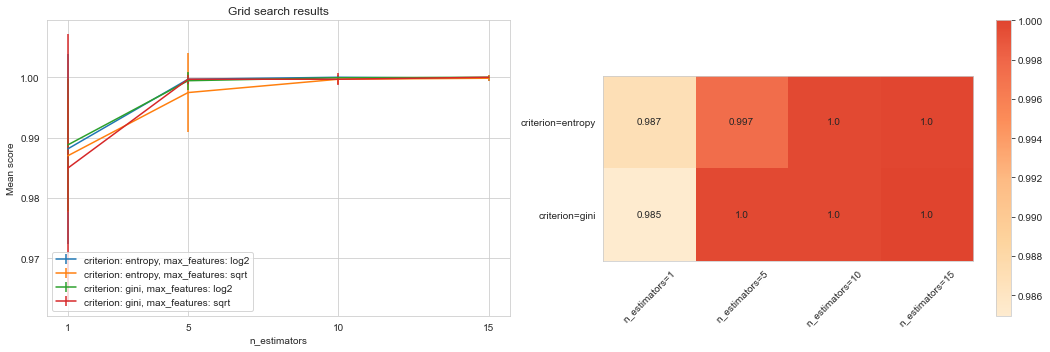

In [186]:
# grid search graphs
f, axes = plt.subplots(1,2,figsize=(15,5))
p1 = grid_search(clf.cv_results_, change='n_estimators',ax=axes[0])
p2 = grid_search(clf.cv_results_, change=('n_estimators', 'criterion'), subset={'max_features': 'sqrt'},ax=axes[1])
plt.grid(False);

I would like to remind that the purpose behind using tuning methods in this data set is just a matter of practice, since the initial results were very satisfying I did not have to tune the models.

### Tuning K-NN (Optuna : Bayesian Optimization)

K-Nearest Neighbors is a supervised learning algorithm that makes predictions on qualitative or quantitative variables. This algorithm is made up of several steps. First, we must choose the number K of neighbors, the default value of K is 5. We must then take the K-nearest neighbors of the new data point based on the Euclidean distance, the Hamming distance, the Minkowski distance or the Manhattan distance or any other distance that can be considered. The next step is to count the number of data points in each category and then assign the new point to the category that contains the most neighbors, hence the name K-Nearest Neighbors. This classification method does not require the model to be fitted and is easy to implement. Being a non-parametric algorithm, K-NN has no assumptions to consider, unlike parametric models such as linear regression. It should also be noted that K-NN requires homogeneous features and it could be that the algorithm works slowly, is not suitable for imbalanced data and becomes problematic when there are missing values

In [79]:
def objective(trial):
    # Instantiate scaler
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
                
    # Tune hyperparameters
    n_neighbors = trial.suggest_int("n_neighbors", 1, 30)
    weights = trial.suggest_categorical("weights", ['uniform', 'distance'])
    metric = trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski'])
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
            
    # Make a pipeline
    pipeline = make_pipeline(scaler, knn)

    # Cross-validate the features reduced by dimensionality reduction methods
    kfold = StratifiedKFold(n_splits=10)
    score = cross_val_score(pipeline, X_train_sm, y_train_sm, scoring='accuracy', cv=kfold)
    score = score.mean()
    return score

optuna.logging.set_verbosity(verbosity=optuna.logging.ERROR)

sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

In [80]:
print("Best trial out of 100 is:")
study.best_trial

Best trial out of 100 is:


FrozenTrial(number=10, values=[1.0], datetime_start=datetime.datetime(2022, 2, 3, 11, 40, 19, 259491), datetime_complete=datetime.datetime(2022, 2, 3, 11, 40, 26, 312233), params={'scalers': 'minmax', 'n_neighbors': 11, 'weights': 'distance', 'metric': 'euclidean'}, distributions={'scalers': CategoricalDistribution(choices=('minmax', 'standard', 'robust')), 'n_neighbors': IntUniformDistribution(high=30, low=1, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 'metric': CategoricalDistribution(choices=('euclidean', 'manhattan', 'minkowski'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=10, state=TrialState.COMPLETE, value=None)

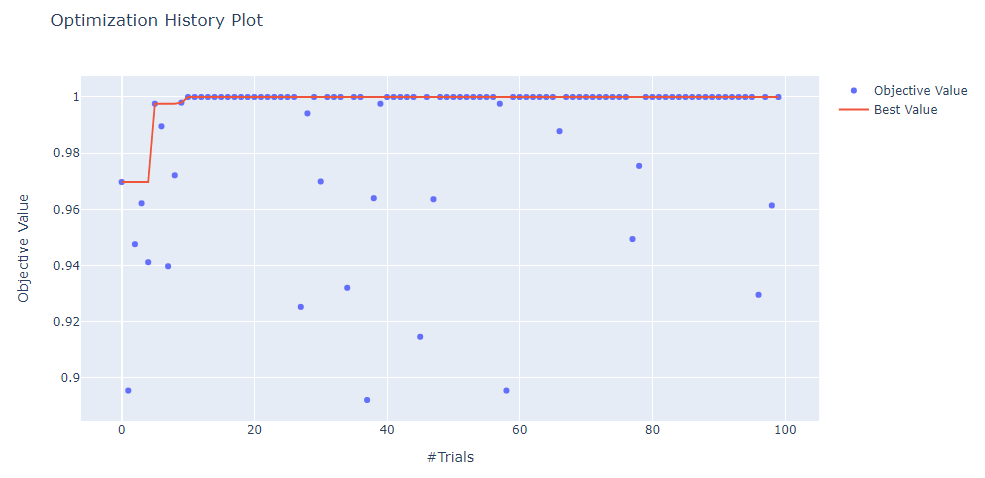

The objective value became almost stable after 10 trials.

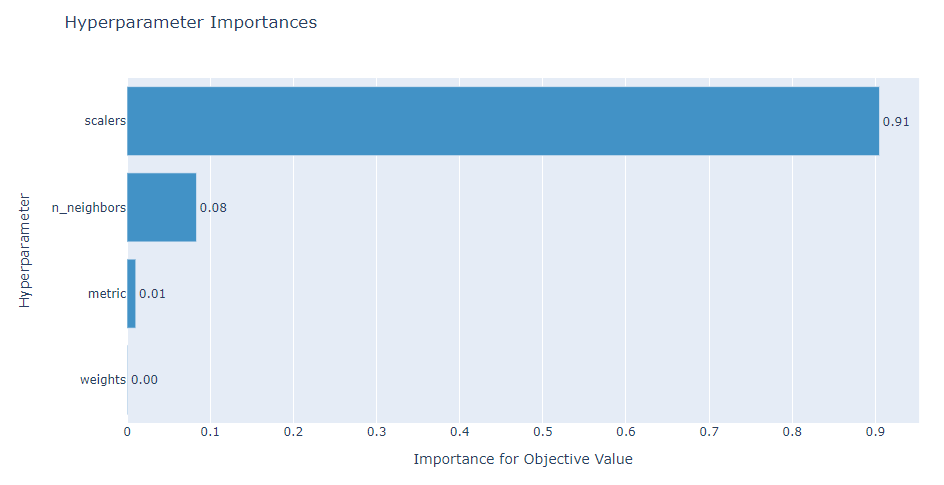

We notice that the most important parameters here are the scalers (which we are going to apply in the next step) and the number of neighbors.

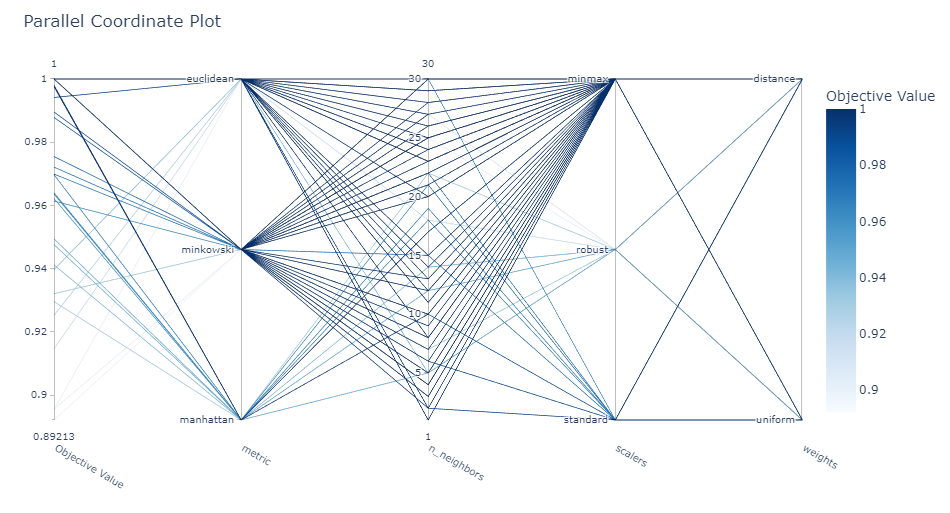

The parallel coordinates plot allows to compare the feature of several individual observations  on a set of numeric variables. Each vertical bar represents a parameter and has its own scale. 

In [84]:
# Have a look at the best parameters for the tuned model
print("Best parameters after tuning using mean accuracy:")
study.best_params

Best parameters after tuning using mean accuracy:


{'scalers': 'minmax',
 'n_neighbors': 11,
 'weights': 'distance',
 'metric': 'euclidean'}

In [85]:
minmax = MinMaxScaler().fit(X_train_sm)
#minmax.fit(X_train)
X_train_minmax = minmax.transform(X_train_sm)
X_valid_minmax = minmax.transform(X_valid)
X_test_minmax = minmax.transform(X_test)

In [88]:
knn = KNeighborsClassifier(n_neighbors=11,weights='distance',metric='euclidean')
knn.fit(X_train_minmax, y_train_sm)

print(f'Train Accuracy : {knn.score(X_train_minmax,y_train_sm).round(3)}')
prediction=knn.predict(X_valid_minmax)
print(f'Validation Accuracy : {accuracy_score(y_valid,prediction).round(3)}')
print(confusion_matrix(y_valid,prediction))
print(classification_report(y_valid,prediction))

Train Accuracy : 1.0
Validation Accuracy : 1.0
[[1757    0]
 [   0  243]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1757
           1       1.00      1.00      1.00       243

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



- **Precision :**
Precision, also known as Positive Prediction Value (PPV), shows the proportion of true positive predictions, i.e. how many predictions were truly positive out of the total positive predicted values. Precision is good to use when there is an important proportion of FP, which should be minimized.
$$Precision = \frac{TP}{TP+FP}$$

- **Recall :**
Also known as True Positive Rate (TPR) or Sensitivity, Recall is a classification error metric which shows how many predictions were correctly predicted out of the total positive actual values. This metric is preferred when there is a large proportion of FN, which should be minimized.
$$Recall = \frac{TP}{TP+FN}$$

- **F-Score :**
F-Score or F-Measure combines both precision and recall into a unique measure that captures both properties. The general F-Beta formula is :
$$F_{\beta} = (1+\beta^2)\frac{Precision*Recall}{(\beta^2*Precision)+Recall}$$
Selecting the beta value depends on FP and FN.\
If FP and FN are equally important, $\beta=1$ and thus the formula becomes :
$$F_{1} = 2*\frac{Precision*Recall}{Precision+Recall}$$ which is basically the harmonic mean of precision and recall, in this case it is called $F_1$-Score.
If FP are more important than FN (i.e. more weight on precision), the beta will be reduced to a range between 0 and 1, a $\beta=0.5$ for instance refers to an $F_{0.5}$-Score.
Finally, if FN have a higher impact than FP (i.e. more weight on recall), beta value will be higher than 1, a $\beta=2$ for instance refers to an $F_{2}$-Score and so on.

In [87]:
# KNN Permutation Feature Importance (on the validation set)
r = permutation_importance(knn, X_valid_minmax, y_valid,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train_sm.columns[i]:<8} "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

isNewBuilt 0.127 +/- 0.006
Pool     0.123 +/- 0.005
Yard     0.119 +/- 0.005
numPrevOwners 0.002 +/- 0.001
attic    0.001 +/- 0.001


The permutation feature importance is the decrease in a model score when a single feature value is randomly shuffled. After training the model, we measure the importance of the features. For isntance, if we look at the 'isNewBuilt' column, we permute this column randomly and we measure the decrease in the metric (accuracy for instance) compared to the non-permutated case. This decrease can be interpreted as the column importance. In this example I chose 30 iterations and the decrease in performance is calculated in each iteration. For the 'isNewbuilt' column for instance, the 0.127 represents the mean by which the performance of the model decreased on the 30 iterations and 0.006 is the standard deviation.

# Clustering

We decided to use COVID-19 database to implement some techniques such as :
- **Clustering with GMM algorithm**
- **BIC ICL and AIC criteria**
- **PCA** 


### Preprocessing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Import database
data = pd.read_csv('CovidCases.csv', sep = ',')
data.head()

,ID,Country,TotalCases,TotalDeaths,TotalRecovered,ActiveCases,TotalCasesPerMillion,TotalDeathsPerMillion,TotalTests,TotalTestsPerMillion,TotalPopulation
0,1,Yemen,9369,1778.0,5921,1670,306,58.0,265253.0,8651.0,30660443
1,2,Vietnam,839662,20555.0,782199,36908,8529,209.0,42517091.0,431850.0,98453377
2,3,Uzbekistan,178637,1271.0,174213,3153,5241,37.0,1377915.0,40425.0,34086135
3,4,UAE,737890,2114.0,731295,4481,73477,211.0,87246490.0,8687776.0,10042442
4,5,Turkey,7444552,66180.0,6893476,484896,87077,774.0,89847975.0,1050928.0,85493959


In [5]:
print(data.shape)
data.info()

(49, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     49 non-null     int64  
 1   Country                49 non-null     object 
 2   TotalCases             49 non-null     int64  
 3   TotalDeaths            48 non-null     float64
 4   TotalRecovered         49 non-null     int64  
 5   ActiveCases            49 non-null     int64  
 6   TotalCasesPerMillion   49 non-null     int64  
 7   TotalDeathsPerMillion  48 non-null     float64
 8   TotalTests             48 non-null     float64
 9   TotalTestsPerMillion   48 non-null     float64
 10  TotalPopulation        49 non-null     int64  
dtypes: float64(4), int64(6), object(1)
memory usage: 4.3+ KB


In [6]:
# Copy
X = data.copy()

# Remvoe ID and Country features which will not be usefull for the clustering
X.drop(['ID'], axis=1, inplace=True)
X.drop(['Country'], axis = 1, inplace= True)

# Missing values check
X.isnull().sum(axis=0)

TotalCases               0
TotalDeaths              1
TotalRecovered           0
ActiveCases              0
TotalCasesPerMillion     0
TotalDeathsPerMillion    1
TotalTests               1
TotalTestsPerMillion     1
TotalPopulation          0
dtype: int64

On observe une valeur manquante pour chacune des variables TotalDeaths, TotalDeathsPerMillion, TotalTests et TotalTestsPerMillion.

Il existe plusieurs manières de gérer les valeurs manquantes
- Remplacer cette valeur par la moyenne ou la médiane de notre dataset
- Utiliser la fonction fillna qui propose 4 méthodes de remplissage des valeurs manquantes : 
    - pad/ffill qui consistent à remplacer la valeur manquante par celle qui lui précède dans le dataset
    - backfill/bfill qui remplacent la valeur manquante par la suivante

Puisque notre jeu de données ne possède qu'un faible nombre d'observations, nous n'avons pas souhaité remplacer cette valeur par la moyenne ou la médiane. Nous n'avons également pas souhaité utiliser la méthode fillna qui ne nous semble pas adaptée dans notre cas. En effet, remplacer par exemple le nombre de morts pour un pays par le nombre de morts d'un autre pays (qui n'a pas la même nombre d'habitants) ne nous semble pas convenable. Nous avons donc décidé de supprimer ces lignes

There is a missing value for each of the variables TotalDeaths, TotalDeathsPerMillion, TotalTests and TotalTestsPerMillion.

There are several ways to handle missing values:
- Replace this value with the mean or median of our dataset
- Use the fillna function which offers 4 methods of filling missing values: 
    - pad/ffill which consist in replacing the missing value by the one preceding it in the dataset
    - backfill/bfill which replace the missing value with the next one

Since our dataset has only a small number of observations, we did not want to replace this value by the mean or the median. We also did not want to use the fillna method, which does not seem to be adapted to our case. Indeed, replacing for example the number of deaths for a country by the number of deaths of another country (which does not have the same number of inhabitants) does not seem appropriate to us. Therefore, we have decided to delete these lines

In [7]:
X = X.dropna()

# Cpnvert as integer
X = X.astype(int)

### Data Analysis

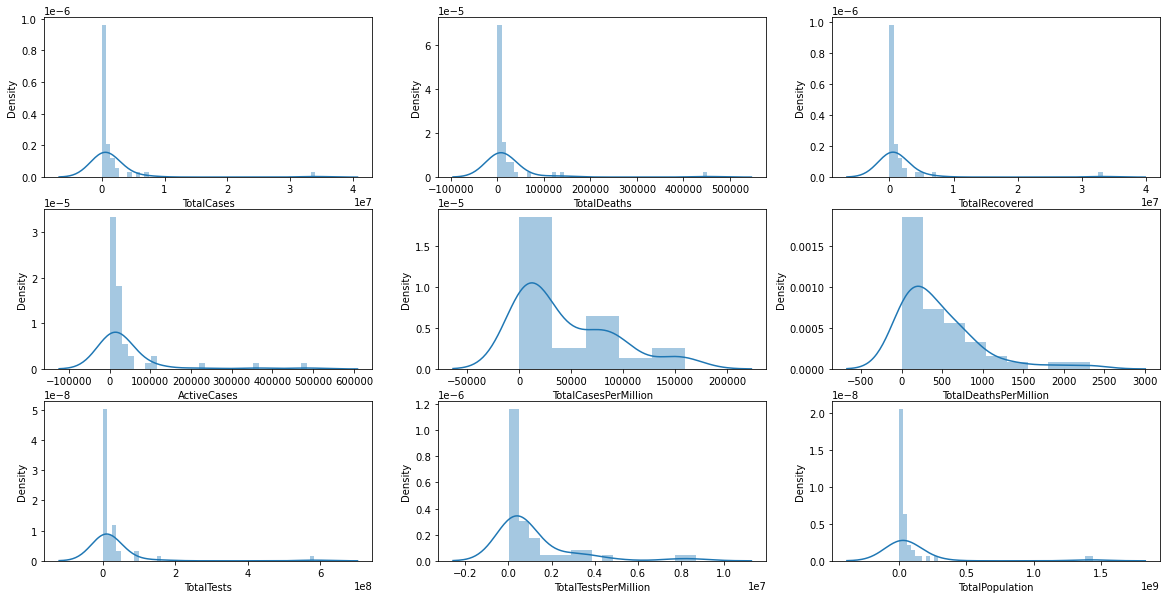

In [8]:
# Distribution of each variable
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
sns.distplot(data['TotalCases'], ax = axes[0,0]);
sns.distplot(data['TotalDeaths'], ax = axes[0,1]);
sns.distplot(data['TotalRecovered'], ax = axes[0,2]);
sns.distplot(data['ActiveCases'], ax = axes[1,0]);
sns.distplot(data['TotalCasesPerMillion'], ax = axes[1,1]);
sns.distplot(data['TotalDeathsPerMillion'], ax = axes[1,2]);
sns.distplot(data['TotalTests'], ax = axes[2,0]);
sns.distplot(data['TotalTestsPerMillion'], ax = axes[2,1])
sns.distplot(data['TotalPopulation'], ax = axes[2,2]);
plt.show()

We can see that most of the variables follow a Gaussian distribution except for the variables TotalCasesPerMillion, TotalTestsPerMillion and TotalDeathPerMillion

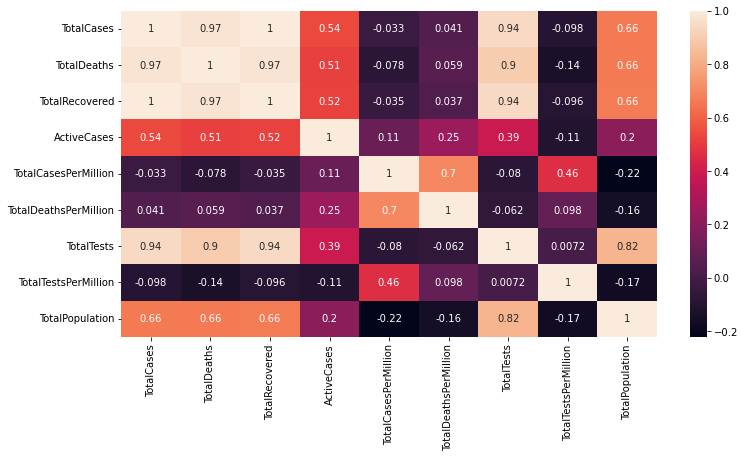

In [9]:
# Correlation
corrMatrix = X.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corrMatrix, annot = True);

### Clustering - GMM

**Summary :**
- 1. Use of raw data without dimension reduction
- 2. Dimension reduction with PCA - 2D
- 3. Dimension reduction with PCA - 3D

#### 1. Use of raw data without dimension reduction

In [10]:
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.mixture import GaussianMixture
from sklearn import mixture
from sklearn.metrics import silhouette_score
import itertools

In [11]:
# Standardize Data
scaler = StandardScaler() 
scaled_X = scaler.fit_transform(X) 
  
# Normalizing the Data
normalized_X = normalize(scaled_X) 
normalized_X = pd.DataFrame(normalized_X) 

normalized_X.head()

,0,1,2,3,4,5,6,7,8
0,-0.195696,-0.195218,-0.192462,-0.274204,-0.591646,-0.501332,-0.206787,-0.383017,-0.143258
1,-0.147685,-0.049149,-0.149296,-0.063428,-0.744290,-0.484299,0.131356,-0.379068,-0.001020
2,-0.182550,-0.207766,-0.178810,-0.275183,-0.548826,-0.548710,-0.207207,-0.387985,-0.141600
3,-0.042954,-0.076244,-0.041008,-0.101352,0.143551,-0.124011,0.156586,0.956247,-0.073995
4,0.218123,0.114287,0.204657,0.915197,0.169043,0.119445,0.129427,-0.014854,-0.008752


**Use of the GMM algorithm with the BIC selection criterion**

The GMM algorithm contains two main parameters:
- **n_components** : number of clusters
- **covariance_type** : type of covariance

We will use the **BIC** criterion to select the best model. It corresponds to the lowest BIC score. So, using a for loop, we will first go through our model with different possible values for the number of clusters and we will indicate the best model thanks to the BIC criterion.

Another criterion can be used to determine the performance of clustering. It is the **Silhouette Score**. For each value, we calculate the distance between our sample and the closest sample which belongs to the other class. This is called the silhouette coefficient. The silhouette score returns the average silhouette coefficient over all samples with the following properties: 
- 1 is the highest value
- -1 is the lowest value
- 0 indicates overlapping clusters
- Negative values generally indicate that a sample has been assigned to the wrong group, as a different group is more similar

In [14]:
# BIC equals infinity (we want to minimize)
lowest_bic = np.infty
# List that contains the different BIC score
bic = []
# List that contains the silhouette score
s = []

n_components_range = range(2, 7)

# For loop on the number of components/clusters of the model
for n_components in n_components_range:
        # GMM algorithm
        gmm = mixture.GaussianMixture(n_components=n_components, random_state = 0)
        gmm.fit(normalized_X)
        # Silhouette score calculation
        sscore =  silhouette_score(normalized_X,gmm.predict(normalized_X)).round(3)
        # Adding the silhouette score to the list s
        s.append(sscore)
        # Adding the BIC score to the list bic
        bic.append(gmm.bic(normalized_X).round(2))
        # If the criterion bic found is lower than lowest_bic, then it becomes the new lowest_bic
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
# clf contains the best gmm model
clf = best_gmm
# silhouette contains the best gmm model silhouette score
silhouette = silhouette_score(normalized_X, best_gmm.predict(normalized_X)).round(3)
print("Silhouette score for the selected model \n", clf, "is", silhouette, " for a BIC score of ", min(bic))

Silhouette score for the selected model 
 GaussianMixture(n_components=6, random_state=0) is 0.417  for a BIC score of  -745.32


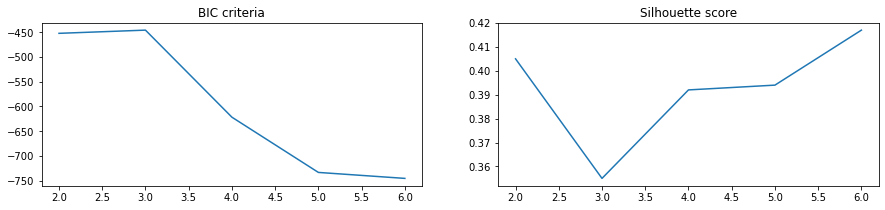

In [15]:
plt.figure(figsize=(15,3))

ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.title.set_text('BIC criteria')
ax1.plot(n_components_range, bic)

ax2.title.set_text('Silhouette score')
ax2.plot(n_components_range,s);

We observe here that the number of clusters that minimizes the BIC criterion is 6. This is also the highest silhouette score.

**In the following, we will integrate the type of covariance in the search for the best model**.

The type of covariance will allow us to visualize the clusters in different shapes

In [16]:
# Formatting the algorithm as a function
def algo_gmm(X):
    lowest_bic = np.infty
    bic = []
    s = []
    n_components_range = range(2, 7)
    cv_types = ["spherical", "tied", "diag", "full"]
    for cv_type in cv_types:
        for n_components in n_components_range:
            gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
            gmm.fit(X)
            sscore =  silhouette_score(X,gmm.predict(X)).round(3)
            s.append(sscore)
            bic.append(gmm.bic(X).round(2))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    bic = np.array(bic)
    clf = best_gmm
    silhouette = silhouette_score(X, best_gmm.predict(X)).round(3)
    return clf, bic, silhouette, n_components_range

In [17]:
for i in range(1,11):
    best_gmm, min_bic, silhouette, n_components_range = algo_gmm(normalized_X)
    print("***** Round ", i, " : Model : ", best_gmm, " BIC : ", min(bic), " Silhouette score : ", silhouette)

***** Round  1  : Model :  GaussianMixture(n_components=5)  BIC :  -745.32  Silhouette score :  0.408
***** Round  2  : Model :  GaussianMixture(n_components=6)  BIC :  -745.32  Silhouette score :  0.244
***** Round  3  : Model :  GaussianMixture(n_components=6)  BIC :  -745.32  Silhouette score :  0.438
***** Round  4  : Model :  GaussianMixture(n_components=5)  BIC :  -745.32  Silhouette score :  0.395
***** Round  5  : Model :  GaussianMixture(n_components=5)  BIC :  -745.32  Silhouette score :  0.298
***** Round  6  : Model :  GaussianMixture(n_components=6)  BIC :  -745.32  Silhouette score :  0.306
***** Round  7  : Model :  GaussianMixture(n_components=6)  BIC :  -745.32  Silhouette score :  0.42
***** Round  8  : Model :  GaussianMixture(n_components=5)  BIC :  -745.32  Silhouette score :  0.35
***** Round  9  : Model :  GaussianMixture(n_components=6)  BIC :  -745.32  Silhouette score :  0.446
***** Round  10  : Model :  GaussianMixture(n_components=6)  BIC :  -745.32  Silhoue

We can also visualize to which classes our data belong

In [18]:
best_gmm.predict(normalized_X)

array([1, 1, 1, 3, 2, 1, 2, 1, 1, 4, 1, 1, 1, 3, 2, 0, 1, 3, 1, 1, 3, 3,
       2, 0, 1, 1, 3, 4, 0, 1, 3, 4, 2, 5, 5, 1, 0, 3, 5, 1, 1, 1, 1, 3,
       4, 0, 1], dtype=int64)

We will create a dataframe of size (1,9) that will contain the average of each column of our dataframe.
This will allow us to predict which class the average of our data would belong to

In [19]:
# Mean of each column
X_mean = X.mean(axis = 0)

# Creation and filling of the dataset
X_new = pd.DataFrame(0, index = [0], columns = list(X_mean.index))
i = 0
for col in X_new.columns :
    X_new[col] = X_mean.values[i]
    i = i + 1
X_new

,TotalCases,TotalDeaths,TotalRecovered,ActiveCases,TotalCasesPerMillion,TotalDeathsPerMillion,TotalTests,TotalTestsPerMillion,TotalPopulation
0,1.641313e+06,24235.255319,1.573923e+06,43154.12766,45698.957447,464.787234,3.015736e+07,1.198093e+06,9.876898e+07


In [20]:
# Standardize Data
scaler = StandardScaler() 
scaled_X_new = scaler.fit_transform(X_new) 
  
# Normalizing data
normalized_X_new = normalize(scaled_X_new) 
normalized_X_new = pd.DataFrame(normalized_X_new) 

In [21]:
# Prediction on the new dataframe
best_gmm.predict(normalized_X_new)

array([1], dtype=int64)

The average of our data would belong to the class 1

The predict_proba function displays the probability that our point belongs to each class.
This function allows us not only to assign a point to a cluster but also to check if the point could not have belonged to a different cluster. If we want, we can assign a different status to these points.

In [22]:
# Use of predict_proba function
predict_proba = best_gmm.predict_proba(normalized_X)
predict_proba = pd.DataFrame(predict_proba)

# Adding max column to get the max proba of each raw and check if our values are satisfying
predict_proba['Max_proba'] = predict_proba.max(axis = 1)

predict_proba[predict_proba['Max_proba'] < 0.5]

,0,1,2,3,4,5,Max_proba


No proba max below 0.5. The results are satisfying 

**In the following, we will use dimension reduction via PCA to visualize our clusters**.

#### 2. Dimension reduction with PCA - 2D

In [23]:
from sklearn.decomposition import PCA

# PCA dimension reduction
pca = PCA(n_components = 2) 
X_reduced = pca.fit_transform(normalized_X) 
X_reduced = pd.DataFrame(X_reduced) 
X_reduced.columns = ['P1', 'P2'] 
  
X_reduced.head(2)

,P1,P2
0,-0.725313,-0.121381
1,-0.774773,0.145930


We observe that when the random_state is different from 0, the results are different. To make sure to have an optimal result, we will run the algorithm with several different values

In [24]:
for i in range(1,11):
    best_gmm, bic, silhouette, n_components_range = algo_gmm(X_reduced)
    print("***** Round ", i, " : Model : ", best_gmm, " BIC : ", min(bic), " Silhouette score : ", silhouette)

***** Round  1  : Model :  GaussianMixture(n_components=2)  BIC :  116.85  Silhouette score :  0.404
***** Round  2  : Model :  GaussianMixture(n_components=2)  BIC :  116.85  Silhouette score :  0.404
***** Round  3  : Model :  GaussianMixture(n_components=2)  BIC :  116.85  Silhouette score :  0.404
***** Round  4  : Model :  GaussianMixture(n_components=2)  BIC :  116.85  Silhouette score :  0.404
***** Round  5  : Model :  GaussianMixture(n_components=2)  BIC :  116.85  Silhouette score :  0.404
***** Round  6  : Model :  GaussianMixture(n_components=2)  BIC :  116.85  Silhouette score :  0.404
***** Round  7  : Model :  GaussianMixture(n_components=2)  BIC :  116.85  Silhouette score :  0.404
***** Round  8  : Model :  GaussianMixture(n_components=2)  BIC :  116.85  Silhouette score :  0.404
***** Round  9  : Model :  GaussianMixture(n_components=2)  BIC :  116.85  Silhouette score :  0.404
***** Round  10  : Model :  GaussianMixture(n_components=2)  BIC :  116.85  Silhouette scor

We do not have any specification for the covariance type of the model. Therefore, it is the default covariance which is of type full

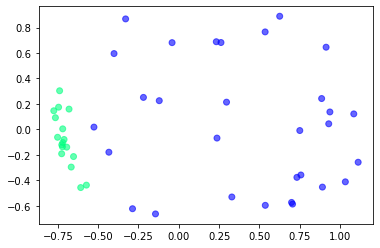

In [25]:
# Model
gmm = GaussianMixture(n_components = 2) 
gmm.fit(X_reduced)
cluster = gmm.predict(X_reduced)

# Visualizing the clustering 
plt.scatter(X_reduced['P1'], X_reduced['P2'],  
           c = GaussianMixture(n_components = 2).fit_predict(X_reduced), cmap =plt.cm.winter, alpha = 0.6) 
plt.show()

- **ICL criterion**

We can observe that the classes are not homogeneous. There is a criterion that would have allowed us to obtain more homogeneous classes: the ICL criterion. **It would be the most optimal criterion for model selection in a clustering case.** It is a BIC criterion with a penalty when the classes are not homogeneous enough. Due to the lack of implementation of the function in the python libraries, we will not use this criterion.
The models will continue to be selected with the BIC criterion.

- **AIC criterion**

Another very popular model selection criterion is the AIC criterion. **Warning ! It is not recommended to use the AIC criterion when you have a clustering problem.** The purpose of this criterion is to try to do density estimation. It will propose as many classes as possible to improve the fit to the data. Its goal is not to find clusters. It has not been developed in a Gaussian setting. We will see this with the graph below:

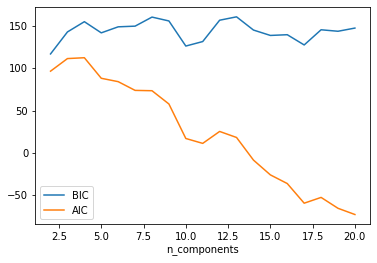

In [26]:
n_components = np.arange(2, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_reduced)
          for n in n_components]

plt.plot(n_components, [m.bic(X_reduced) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_reduced) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

As we can see, the AIC criterion suggests taking the largest number of clusters while the BIC criterion finds its minimum at 2 clusters. The more the number of iterations is large, the more the AIC criterion moves away from the BIC criterion until it completely moves away from it.

#### 3. Dimension reduction with PCA - 3D

In [29]:
# Dimension reduction
pca = PCA(n_components = 3) 
X_principal = pca.fit_transform(normalized_X) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2', 'P3'] 

# GMM
for i in range(1,11):
    best_gmm, bic, silhouette, n_components_range = algo_gmm(X_principal)
    print("***** Round ", i, " : Model : ", best_gmm, " BIC : ", min(bic), " Silhouette score : ", silhouette)

***** Round  1  : Model :  GaussianMixture(covariance_type='diag', n_components=2)  BIC :  161.8  Silhouette score :  0.287
***** Round  2  : Model :  GaussianMixture(covariance_type='diag', n_components=2)  BIC :  161.8  Silhouette score :  0.287
***** Round  3  : Model :  GaussianMixture(covariance_type='diag', n_components=2)  BIC :  161.8  Silhouette score :  0.287
***** Round  4  : Model :  GaussianMixture(covariance_type='diag', n_components=2)  BIC :  161.8  Silhouette score :  0.287
***** Round  5  : Model :  GaussianMixture(covariance_type='diag', n_components=2)  BIC :  161.8  Silhouette score :  0.287
***** Round  6  : Model :  GaussianMixture(covariance_type='diag', n_components=2)  BIC :  161.8  Silhouette score :  0.287
***** Round  7  : Model :  GaussianMixture(covariance_type='diag', n_components=2)  BIC :  161.8  Silhouette score :  0.287
***** Round  8  : Model :  GaussianMixture(covariance_type='diag', n_components=2)  BIC :  161.8  Silhouette score :  0.287
***** Ro

We choose the GMM with 6 components because it has the best silhouette score

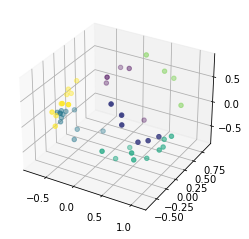

In [30]:
# 3D plot result
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_principal['P1'], X_principal['P2'], X_principal['P3'],
            c = GaussianMixture(n_components = 6).fit_predict(X_principal))
plt.show()